# Question 3: CIFAR-10 Classification using CNN 
- Please **do not** change the default variable names in this problem, as we will use them in different parts.
- The default variables are initially set to "None".


In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import *
import random 
from tqdm import tqdm 
import warnings 

In [2]:
def imshow(img):
  img = img / 2 + 0.5   # unnormalize
  npimg = img.numpy()   # convert from tensor
  plt.imshow(np.transpose(npimg, (1, 2, 0))) 
  plt.show()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR10/train/cifar-10-python.tar.gz to ./CIFAR10/train


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR10/test/cifar-10-python.tar.gz to ./CIFAR10/test


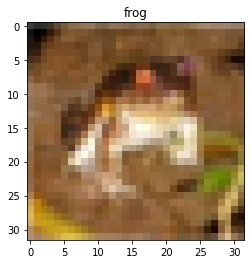

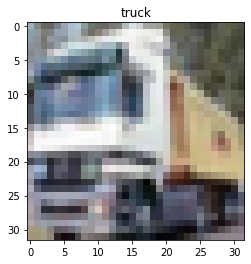

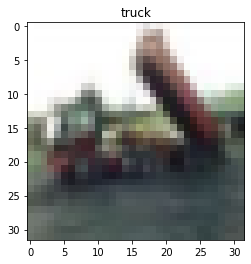

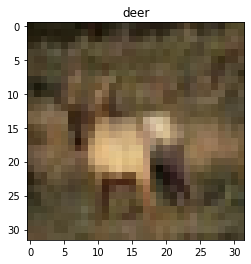

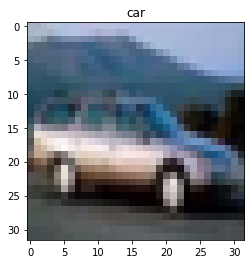

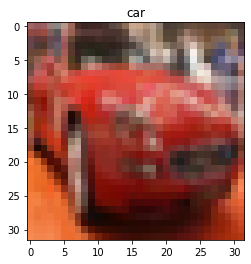

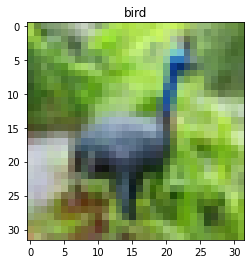

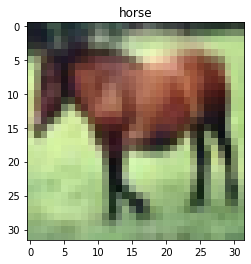

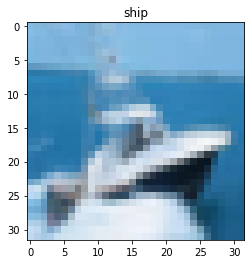

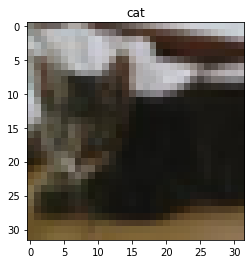

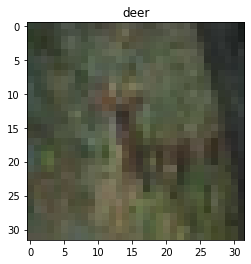

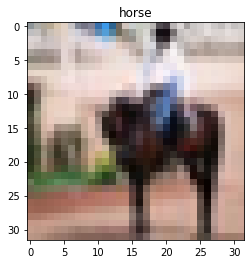

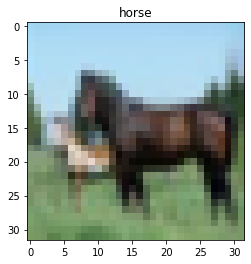

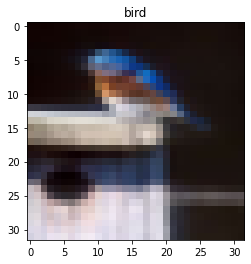

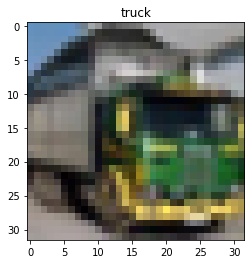

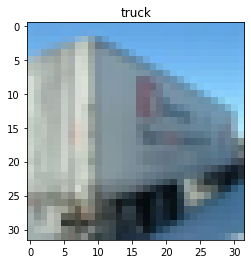

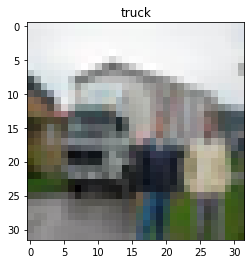

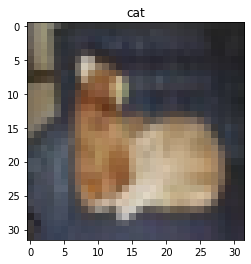

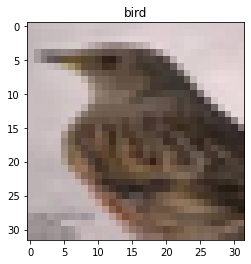

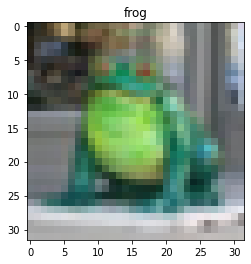

In [3]:

# The below two lines are optional and are just there to avoid any SSL
# related errors while downloading the CIFAR-10 dataset
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#Initializing normalizing transform for the dataset
normalize_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.5, 0.5, 0.5),
                                    std = (0.5, 0.5, 0.5))])

#Downloading the CIFAR10 dataset into train and test sets
train_dataset = torchvision.datasets.CIFAR10(
    root="./CIFAR10/train", train=True,
    transform=normalize_transform,
    download=True)
    
test_dataset = torchvision.datasets.CIFAR10(
    root="./CIFAR10/test", train=False,
    transform=normalize_transform,
    download=True)


#Generating data loaders from the corresponding datasets
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)




classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
'frog', 'horse', 'ship', 'truck')

# get first 100 training images
dataiter = iter(train_loader)
imgs, lbls = dataiter.next()

for i in range(20):  
    plt.title(classes[lbls[i]])
    imshow(imgs[i])

In [4]:
# check pytorch cuda and use cuda if possible
device = torch.cuda.is_available()
print('*' * 50)
if torch.cuda.is_available():  
  print('CUDA is found! Tranining on %s.......'%torch.cuda.get_device_name(0))
else:
  warnings.warn('CUDA not found! Training may be slow......')

**************************************************
CUDA is found! Tranining on Tesla T4.......


## P1. Build you own CNN model 
### TODO
- Design your model class in **CNNModel(nn.Module)** and write forward pass in **forward(self, x)**
- Create loss function in **error**, optimizer in **optimizer**
- Define hyparparameters: **learning_rate**, **num_epochs**
- Plot your **loss vs num_epochs** and **accuracy vs num_epochs** 


###  Hints
- Start with low number of epochs for debugging. (eg. num_epochs=1)
- Be careful with the input dimension of fully connected layer. 
- The dimension calculation of the output tensor from the input tensor is \\
$D_{out}=\frac{D_{in}-K+2P}{S}+1$ \\
$D_{out}$ : Dimension of output tensor \\
$D_{in}$ : Dimension of input tensor \\
$K$ : width/height of the kernel \\
$S$ : stride \\
$P$ : padding

## Convolutional and Pooling Layers

A convolutional layer using pyTorch:



```
torch.nn.Conv2d(num_in_channels, num_out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
```
For example:
```
torch.nn.Conv2d(3, 32, 3)
```
It applies a 2D convolution over an input signal composed of several input planes. If we have input size with $(N, C_{in}, H, W)$ and output size with $(N, C_{out}, H_{out}, W_{out})$, the 2D convolution can described as $$out(N_i, C_{out_j}) = bias(C_{out_j}) + \sum_{k=0}^{C_{in}-1}weight(C_{out_j},k)\star input(N_i,k)$$

**num_in_channels:** is the number of channels of the input tensor. If the previous layer is the input layer, num_in_channels is the number of channels of the image (3 channels for RGB images), otherwise num_in_channels is equal to the number of feature maps of the previous layer.

**num_out_channels:** is the number of filters (feature extractor) that this layer will apply over the image or feature maps generated by the previous layer.

**kernel_size:** is the size of the convolving kernel

**stride:** is the stride of the convolution. Default: 1

**padding:** is the padding added to all four sides of the input. Default: 0

**dilation:** is the spacing between kernel elements. Default: 1

**group:** is the number of blocked connections from input channels to output channels. Default: 1

**bias:** If True, adds a learnable bias to the output. Default: True

## A Simple Convolutional Neural Network

In our convnet we'll initally use this structure shown below:

*input -> convolution -> fully connected -> output* \\


At the end of the last convolutional layer, we get a tensor of dimension (num_channels, height, width). Since now we are going to feed it to a fully connected layer, we need to convert it into a 1-D vector, and for that we use the reshape method:

```
x = x.view(x.size(0), -1)
```
The way of calculating size of the output size from previous convolution layer can be formulized as below: $$H_{output} = \frac{H_{in}+2\times padding-kernel\_Size}{stride}+1$$

For more details, you can refer to this link: \\
https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [8]:
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    # TODO: Create CNNModel using 2D convolution. You should vary the number of convolution layers and fully connected layers
    # In this function, you should define each of the individual components of the CNN that you will use in your network 
    # Example:  
    # self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
    # self.relu1 = nn.ReLU() 
    # self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
#     self.cnn1 = None   
    #Input = 3 x 32 x 32, Output = 6 x 28 x 28
    self.cnn1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
    #Input = 6 x 28 x 28, Output = 6 x 28 x 28
    self.relu1 = nn.ReLU() 
    #Input = 6 x 28 x 28, Output = 16 x 26 x 26
    self.cnn2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=0)
    #Input = 16 x 26 x 26, Output = 16 x 26 x 26
    self.relu2 = nn.ReLU() 
    #Input = 16 x 26 x 26, Output = 24 x 24 x 24
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3, stride=1, padding=0)
    #Input = 24 x 24 x 24, Output = 24 x 24 x 24
    self.relu3 = nn.ReLU() 
    # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer 
    # Example: 
    # self.fc1 = nn.Linear(16 *110 * 110, 5)
    # Fully connected 1
#     self.fc1 = None
    self.flatten =  nn.Flatten()
    
    self.fc1 = nn.Linear(24 * 24 * 24, 120)
    self.relu4 = nn.ReLU() 
    self.fc2 = nn.Linear(120, 84)
    self.relu5 = nn.ReLU() 
    self.fc3 = nn.Linear(84, 10)

  def forward(self,x):

    # TODO: Perform forward pass in below section 
    # In this function, you will apply the components defined earlier to the input, x.
    # Example:
    # out = self.cnn1(x)
    # out = self.relu1(out)      
    # out = self.maxpool1(out) 
    # to visualize feature map in part a, part b.i), use the following three lines:
  
    # plt.imshow(out[0][0].cpu().detach().numpy())
    # plt.show()
    # plt.close('all')
    # out = out.view(out.size(0), -1)
    # out = self.fc1(out)
    out = self.cnn1(x)
    out = self.relu1(out)
    out = self.cnn2(out)
    out = self.relu2(out)

    feature_map = out[0][0].cpu().detach().numpy()

    out = self.cnn3(out)
    out = self.relu3(out)
    
    out = self.flatten(out)

    out = self.fc1(out)
    out = self.relu4(out)
    out = self.fc2(out)
    out = self.relu5(out)
    out = self.fc3(out) 
    
#     out = None
    return out, feature_map

## Starting Up Our Model

We'll send the model to our GPU if you have one so we need to create a CUDA device and instantiate our model. Then we will define the loss function and 
hyperparameters that we need to train the model: \\

###TODO
- Define Cross Entropy Loss
- Create Adam Optimizer
- Define hyperparameters 

In [9]:
# Create CNN
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNModel()
model.to(device)

# TODO: define Cross Entropy Loss 
error = torch.nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters 
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 20

### Training the Model
### TODO 
- Make predictions from your model
- Calculate Cross Entropy Loss from predictions and labels 

  0%|          | 0/20 [00:00<?, ?it/s]

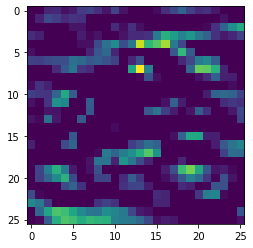

  5%|▌         | 1/20 [00:26<08:21, 26.39s/it]

Iteration: 500  Loss: 0.27344074845314026  Accuracy: 57.75 %


 10%|█         | 2/20 [00:54<08:10, 27.26s/it]

Iteration: 1000  Loss: 0.23714624345302582  Accuracy: 57.75 %


 15%|█▌        | 3/20 [01:23<07:55, 27.98s/it]

Iteration: 1500  Loss: 0.17975905537605286  Accuracy: 57.75 %


 25%|██▌       | 5/20 [02:18<06:57, 27.85s/it]

Iteration: 2000  Loss: 0.17549538612365723  Accuracy: 57.75 %


 30%|███       | 6/20 [02:43<06:17, 26.99s/it]

Iteration: 2500  Loss: 0.3157724142074585  Accuracy: 57.75 %


 35%|███▌      | 7/20 [03:11<05:53, 27.20s/it]

Iteration: 3000  Loss: 0.1287059485912323  Accuracy: 57.75 %


 40%|████      | 8/20 [03:39<05:30, 27.55s/it]

Iteration: 3500  Loss: 0.1470046192407608  Accuracy: 57.75 %


 50%|█████     | 10/20 [04:34<04:34, 27.42s/it]

Iteration: 4000  Loss: 0.31148678064346313  Accuracy: 57.75 %


 55%|█████▌    | 11/20 [05:01<04:06, 27.34s/it]

Iteration: 4500  Loss: 0.28248921036720276  Accuracy: 57.75 %


 60%|██████    | 12/20 [05:26<03:33, 26.69s/it]

Iteration: 5000  Loss: 0.22544948756694794  Accuracy: 57.75 %


 70%|███████   | 14/20 [06:22<02:42, 27.14s/it]

Iteration: 5500  Loss: 0.3903600573539734  Accuracy: 57.75 %


 75%|███████▌  | 15/20 [06:49<02:16, 27.23s/it]

Iteration: 6000  Loss: 0.31647825241088867  Accuracy: 57.75 %


 80%|████████  | 16/20 [07:16<01:48, 27.21s/it]

Iteration: 6500  Loss: 0.315034419298172  Accuracy: 57.75 %


 85%|████████▌ | 17/20 [07:41<01:19, 26.58s/it]

Iteration: 7000  Loss: 0.15729302167892456  Accuracy: 57.75 %


 95%|█████████▌| 19/20 [08:36<00:27, 27.04s/it]

Iteration: 7500  Loss: 0.13128897547721863  Accuracy: 57.75 %


100%|██████████| 20/20 [09:04<00:00, 27.22s/it]


In [29]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs, feature_map = model(images)
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Backprop agate your Loss 
        loss.backward()
        
        # Update CNN model  
        optimizer.step()
        if count == 0 and i == 0:
          plt.imshow(feature_map)
          plt.show()
          plt.close('all')
          continue
        count += 1
        
        if count % 50 == 0:
            model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward propagation
                outputs, feature_map = model(images)
                
                # Get predictions from the maximum value
                predicted = torch.argmax(outputs,1)
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy.item())
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

In [11]:
# uncomment above line if you don't have torchsummary installed yet
# Print torchsummary of model
from torchsummary import summary
print(summary(model, input_size=(3, 32, 32)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
            Conv2d-3           [-1, 16, 26, 26]             880
              ReLU-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           3,480
              ReLU-6           [-1, 24, 24, 24]               0
           Flatten-7                [-1, 13824]               0
            Linear-8                  [-1, 120]       1,659,000
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 1,674,830
Trainable params: 1,674,830
Non-trainable params: 0
---------------------------

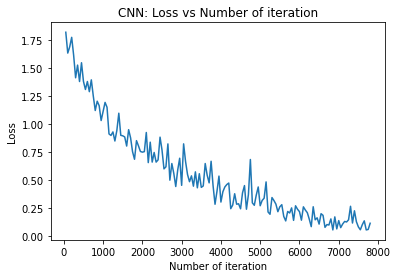

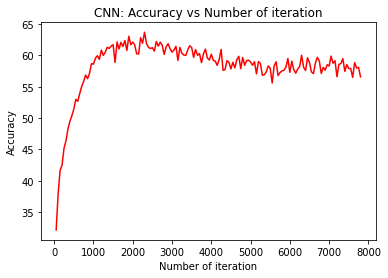

In [12]:
# visualization loss
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

### Evaluating the Model

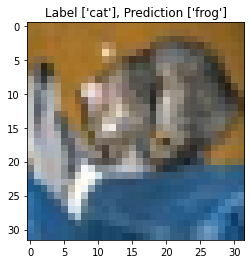

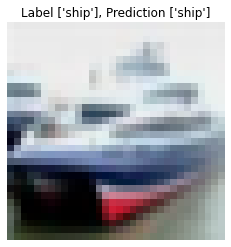

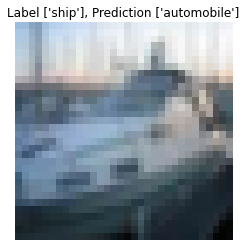

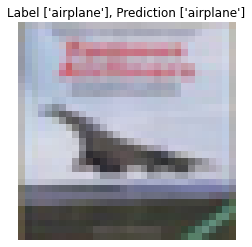

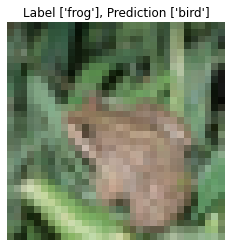

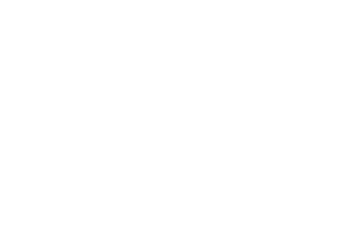

In [13]:

#To-do: evaluate on test set, instead of training set
random_image = random.randint(0,len(test_dataset))
image = test_dataset.__getitem__(random_image)
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
predictions = torch.argmax(model(images)[0],1)
num_cols=1
num_rows = 5# len(labels)
label_map = [['airplane'],['automobile'],['bird'],['cat'], ['deer'], ['dog'], ['frog'], ['horse'], ['ship'], ['truck']]

for idx in range(num_rows):
  img = images.cpu()[idx]
  
  plt.title(f"Label {label_map[labels[idx]]}, Prediction {label_map[predictions[idx]]}")  
  imshow(img)

  plt.axis('off')
plt.show()

# Part b

In [14]:
class CNNModel_addmax(nn.Module):
  def __init__(self):
    super(CNNModel_addmax, self).__init__()
    # TODO: Create CNNModel using 2D convolution. You should vary the number of convolution layers and fully connected layers
    # In this function, you should define each of the individual components of the CNN that you will use in your network 
    # Example:  
    # self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
    # self.relu1 = nn.ReLU() 
    # self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
#     self.cnn1 = None   
    #Input = 3 x 32 x 32, Output = 6 x 28 x 28
    self.cnn1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
    #Input = 6 x 28 x 28, Output = 6 x 28 x 28
    self.relu1 = nn.ReLU() 
    #Input = 6 x 28 x 28, Output = 16 x 26 x 26
    self.cnn2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=0)
    #Input = 16 x 26 x 26, Output = 16 x 26 x 26
    self.relu2 = nn.ReLU() 
    #Input = 16 x 26 x 26, Output = 16 x 13 x 13
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)
    #Input = 16 x 13 x 13, Output = 24 x 11 x 11
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3, stride=1, padding=0)
    #Input = 24 x 11 x 11, Output = 24 x 11 x 11
    self.relu3 = nn.ReLU() 
    # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer 
    # Example: 
    # self.fc1 = nn.Linear(16 *110 * 110, 5)
    # Fully connected 1
#     self.fc1 = None
    self.flatten =  nn.Flatten()
    
    self.fc1 = nn.Linear(24 * 11 * 11, 120)
    self.relu4 = nn.ReLU() 
    self.fc2 = nn.Linear(120, 84)
    self.relu5 = nn.ReLU() 
    self.fc3 = nn.Linear(84, 10)

  def forward(self,x):

    # TODO: Perform forward pass in below section 
    # In this function, you will apply the components defined earlier to the input, x.
    # Example:
    # out = self.cnn1(x)
    # out = self.relu1(out)      
    # out = self.maxpool1(out) 
    # to visualize feature map in part a, part b.i), use the following three lines:
  
    # plt.imshow(out[0][0].cpu().detach().numpy())
    # plt.show()
    # plt.close('all')
    # out = out.view(out.size(0), -1)
    # out = self.fc1(out)
    out = self.cnn1(x)
    out = self.relu1(out)
    out = self.cnn2(out)
    out = self.relu2(out)
    out = self.maxpool1(out)

    # plt.imshow(out[0][0].cpu().detach().numpy())
    # plt.show()
    # plt.close('all')
    feature_map = out[0][0].cpu().detach().numpy()
    out = self.cnn3(out)
    out = self.relu3(out)
    
    out = self.flatten(out)
    
    out = self.fc1(out)
    out = self.relu4(out)
    out = self.fc2(out)
    out = self.relu5(out)
    out = self.fc3(out) 
    
#     out = None
    return out, feature_map

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_addmax = CNNModel_addmax()
model_addmax.to(device)

# TODO: define Cross Entropy Loss 
error = torch.nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters 
learning_rate = 0.001
optimizer = torch.optim.Adam(model_addmax.parameters(), lr=learning_rate)
num_epochs = 20

  0%|          | 0/20 [00:00<?, ?it/s]

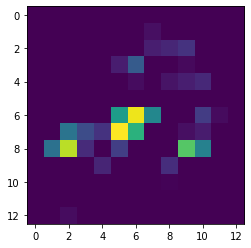

  5%|▌         | 1/20 [00:25<08:04, 25.52s/it]

Iteration: 500  Loss: 0.8445738554000854  Accuracy: 58.28999710083008 %


 10%|█         | 2/20 [00:52<08:00, 26.67s/it]

Iteration: 1000  Loss: 0.8714269399642944  Accuracy: 58.28999710083008 %


 15%|█▌        | 3/20 [01:21<07:46, 27.46s/it]

Iteration: 1500  Loss: 0.6838442087173462  Accuracy: 58.28999710083008 %


 25%|██▌       | 5/20 [02:15<06:49, 27.29s/it]

Iteration: 2000  Loss: 0.8607397675514221  Accuracy: 58.28999710083008 %


 30%|███       | 6/20 [02:41<06:13, 26.69s/it]

Iteration: 2500  Loss: 1.1854737997055054  Accuracy: 58.28999710083008 %


 35%|███▌      | 7/20 [03:08<05:49, 26.90s/it]

Iteration: 3000  Loss: 0.9806298017501831  Accuracy: 58.28999710083008 %


 40%|████      | 8/20 [03:36<05:26, 27.21s/it]

Iteration: 3500  Loss: 0.6123979091644287  Accuracy: 58.28999710083008 %


 50%|█████     | 10/20 [04:31<04:32, 27.26s/it]

Iteration: 4000  Loss: 0.6503430604934692  Accuracy: 58.28999710083008 %


 55%|█████▌    | 11/20 [04:58<04:05, 27.28s/it]

Iteration: 4500  Loss: 0.9387732744216919  Accuracy: 58.28999710083008 %


 60%|██████    | 12/20 [05:23<03:33, 26.67s/it]

Iteration: 5000  Loss: 0.6279237270355225  Accuracy: 58.28999710083008 %


 70%|███████   | 14/20 [06:18<02:42, 27.11s/it]

Iteration: 5500  Loss: 0.9890245199203491  Accuracy: 58.28999710083008 %


 75%|███████▌  | 15/20 [06:46<02:15, 27.15s/it]

Iteration: 6000  Loss: 0.832348108291626  Accuracy: 58.28999710083008 %


 80%|████████  | 16/20 [07:13<01:48, 27.23s/it]

Iteration: 6500  Loss: 0.8773755431175232  Accuracy: 58.28999710083008 %


 85%|████████▌ | 17/20 [07:38<01:19, 26.66s/it]

Iteration: 7000  Loss: 0.7481259107589722  Accuracy: 58.28999710083008 %


 95%|█████████▌| 19/20 [08:34<00:27, 27.19s/it]

Iteration: 7500  Loss: 0.568682849407196  Accuracy: 58.28999710083008 %


100%|██████████| 20/20 [09:01<00:00, 27.09s/it]


In [30]:
count = 0
loss_list_bi = []
iteration_list_bi = []
accuracy_list_bi = []
for epoch in tqdm(range(num_epochs)):
    model_addmax.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs, feature_map = model_addmax(images)
        # if count == 0 and i == 0:
        #   plt.imshow(feature_img)
        #   plt.show()
        #   plt.close('all')
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Backprop agate your Loss 
        loss.backward()
        
        # Update CNN model  
        optimizer.step()
        if count == 0 and i == 0:
          plt.imshow(feature_map)
          plt.show()
          plt.close('all')
          continue
        
        count += 1
        
        if count % 50 == 0:
            model_addmax.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward propagation
                outputs, feature_map = model_addmax(images)
                
                # Get predictions from the maximum value
                predicted = torch.argmax(outputs,1)
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list_bi.append(loss.item())
            iteration_list_bi.append(count)
            accuracy_list_bi.append(accuracy.item())
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

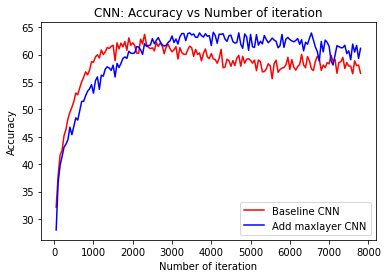

In [17]:
# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.plot(iteration_list_bi,accuracy_list_bi,color = "blue")
plt.legend(['Baseline CNN','Add maxlayer CNN'])
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()


In [18]:
print(summary(model_addmax, input_size=(3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
            Conv2d-3           [-1, 16, 26, 26]             880
              ReLU-4           [-1, 16, 26, 26]               0
         MaxPool2d-5           [-1, 16, 13, 13]               0
            Conv2d-6           [-1, 24, 11, 11]           3,480
              ReLU-7           [-1, 24, 11, 11]               0
           Flatten-8                 [-1, 2904]               0
            Linear-9                  [-1, 120]         348,600
             ReLU-10                  [-1, 120]               0
           Linear-11                   [-1, 84]          10,164
             ReLU-12                   [-1, 84]               0
           Linear-13                   [-1, 10]             850
Total params: 364,430
Trainable params:

Compared to the base CNN, the mermory needed for this CNN is a lot lesser. This is because the max pooling layer performs feature selection and drops less important features. The total trainable parameters are far less than the base CNN.

# Part b
## five layers of convolution

In [19]:
class CNNModel_add(nn.Module):
  def __init__(self):
    super(CNNModel_add, self).__init__()
    # TODO: Create CNNModel using 2D convolution. You should vary the number of convolution layers and fully connected layers
    # In this function, you should define each of the individual components of the CNN that you will use in your network 
    # Example:  
    # self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
    # self.relu1 = nn.ReLU() 
    # self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
#     self.cnn1 = None   
    #Input = 3 x 32 x 32, Output = 6 x 28 x 28
    self.cnn1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
    #Input = 6 x 28 x 28, Output = 6 x 28 x 28
    self.relu1 = nn.ReLU() 
    #Input = 6 x 28 x 28, Output = 16 x 26 x 26
    self.cnn2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=0)
    #Input = 16 x 26 x 26, Output = 16 x 26 x 26
    self.relu2 = nn.ReLU() 
    #Input = 16 x 26 x 26, Output = 16 x 13 x 13
    self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
    #Input = 16 x 13 x 13, Output = 24 x 11 x 11
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3, stride=1, padding=0)
    #Input = 24 x 11 x 11, Output = 24 x 11 x 11
    self.relu3 = nn.ReLU() 
    #Input = 24 x 11 x 11, Output = 24 x 9 x 9
    self.cnn4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=0)
    #Input = 24 x 9 x 9, Output = 24 x 9 x 9
    self.relu4 = nn.ReLU() 
    #Input = 24 x 9 x 9, Output = 24 x 7 x 7
    self.cnn5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=0)
    #Input = 24 x 7 x 7, Output = 24 x 7 x 7
    self.relu5 = nn.ReLU() 
    # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer 
    # Example: 
    # self.fc1 = nn.Linear(16 *110 * 110, 5)
    # Fully connected 1
#     self.fc1 = None
    self.flatten =  nn.Flatten()
    
    self.fc1 = nn.Linear(24 * 7 * 7, 120)
    self.relu4 = nn.ReLU() 
    self.fc2 = nn.Linear(120, 84)
    self.relu5 = nn.ReLU() 
    self.fc3 = nn.Linear(84, 10)

  def forward(self,x):

    # TODO: Perform forward pass in below section 
    # In this function, you will apply the components defined earlier to the input, x.
    # Example:
    # out = self.cnn1(x)
    # out = self.relu1(out)      
    # out = self.maxpool1(out) 
    # to visualize feature map in part a, part b.i), use the following three lines:
  
    # plt.imshow(out[0][0].cpu().detach().numpy())
    # plt.show()
    # plt.close('all')
    # out = out.view(out.size(0), -1)
    # out = self.fc1(out)
    out = self.cnn1(x)
    out = self.relu1(out)
    out = self.cnn2(out)
    out = self.relu2(out)
    out = self.maxpool1(out)
    out = self.cnn3(out)
    out = self.relu3(out)
    out = self.cnn4(out)
    out = self.relu4(out)
    out = self.cnn5(out)
    out = self.relu5(out)
    
    out = self.flatten(out)
    
    out = self.fc1(out)
    out = self.relu4(out)
    out = self.fc2(out)
    out = self.relu5(out)
    out = self.fc3(out) 
    
#     out = None
    return out

In [20]:
# Create CNN
device = "cuda" if torch.cuda.is_available() else "cpu"
model_add = CNNModel_add()
model_add.to(device)

# TODO: define Cross Entropy Loss 
error = torch.nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters 
learning_rate = 0.001
optimizer = torch.optim.Adam(model_add.parameters(), lr=learning_rate)
num_epochs = 20

In [21]:
count = 0
loss_list_bii = []
iteration_list_bii = []
accuracy_list_bii = []
for epoch in tqdm(range(num_epochs)):
    model_add.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs = model_add(images)
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Backprop agate your Loss 
        loss.backward()
        
        # Update CNN model  
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            model_add.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward propagation
                outputs = model_add(images)
                
                # Get predictions from the maximum value
                predicted = torch.argmax(outputs,1)
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list_bii.append(loss.item())
            iteration_list_bii.append(count)
            accuracy_list_bii.append(accuracy.item())
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

  5%|▌         | 1/20 [00:25<08:02, 25.41s/it]

Iteration: 500  Loss: 1.4999983310699463  Accuracy: 42.13999938964844 %


 10%|█         | 2/20 [00:52<07:58, 26.57s/it]

Iteration: 1000  Loss: 1.3886499404907227  Accuracy: 49.04999923706055 %


 15%|█▌        | 3/20 [01:20<07:38, 26.94s/it]

Iteration: 1500  Loss: 1.2012736797332764  Accuracy: 53.30999755859375 %


 25%|██▌       | 5/20 [02:15<06:50, 27.38s/it]

Iteration: 2000  Loss: 1.1973364353179932  Accuracy: 55.29999923706055 %


 30%|███       | 6/20 [02:41<06:13, 26.69s/it]

Iteration: 2500  Loss: 1.1359113454818726  Accuracy: 58.099998474121094 %


 35%|███▌      | 7/20 [03:08<05:49, 26.90s/it]

Iteration: 3000  Loss: 1.2219555377960205  Accuracy: 59.54999923706055 %


 40%|████      | 8/20 [03:35<05:25, 27.10s/it]

Iteration: 3500  Loss: 1.0369904041290283  Accuracy: 59.63999938964844 %


 50%|█████     | 10/20 [04:33<04:39, 27.92s/it]

Iteration: 4000  Loss: 0.9524593949317932  Accuracy: 60.1099967956543 %


 55%|█████▌    | 11/20 [05:01<04:11, 27.94s/it]

Iteration: 4500  Loss: 0.9852827191352844  Accuracy: 60.84000015258789 %


 60%|██████    | 12/20 [05:26<03:37, 27.13s/it]

Iteration: 5000  Loss: 0.8955932259559631  Accuracy: 62.38999938964844 %


 70%|███████   | 14/20 [06:22<02:44, 27.37s/it]

Iteration: 5500  Loss: 0.8918821811676025  Accuracy: 62.37999725341797 %


 75%|███████▌  | 15/20 [06:49<02:16, 27.32s/it]

Iteration: 6000  Loss: 0.677424430847168  Accuracy: 62.46999740600586 %


 80%|████████  | 16/20 [07:16<01:49, 27.26s/it]

Iteration: 6500  Loss: 0.754597008228302  Accuracy: 63.529998779296875 %


 85%|████████▌ | 17/20 [07:41<01:20, 26.70s/it]

Iteration: 7000  Loss: 0.9233964681625366  Accuracy: 63.46999740600586 %


 95%|█████████▌| 19/20 [08:36<00:27, 27.18s/it]

Iteration: 7500  Loss: 0.779556930065155  Accuracy: 63.94999694824219 %


100%|██████████| 20/20 [09:03<00:00, 27.20s/it]


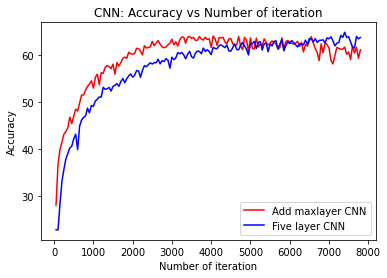

In [22]:
# visualization accuracy 
plt.plot(iteration_list_bi,accuracy_list_bi,color = "red")
plt.plot(iteration_list_bii,accuracy_list_bii,color = "blue")
plt.legend(['Add maxlayer CNN','Five layer CNN'])
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [23]:
print(summary(model_add, input_size=(3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
            Conv2d-3           [-1, 16, 26, 26]             880
              ReLU-4           [-1, 16, 26, 26]               0
         MaxPool2d-5           [-1, 16, 13, 13]               0
            Conv2d-6           [-1, 24, 11, 11]           3,480
              ReLU-7           [-1, 24, 11, 11]               0
            Conv2d-8             [-1, 24, 9, 9]           5,208
              ReLU-9             [-1, 24, 9, 9]               0
           Conv2d-10             [-1, 24, 7, 7]           5,208
             ReLU-11             [-1, 24, 7, 7]               0
          Flatten-12                 [-1, 1176]               0
           Linear-13                  [-1, 120]         141,240
             ReLU-14                  [

Compared to the previous model, this model has less parameters to train. Adding two more convolutional layers that decreases the dimensions before a fully connected layer introduces less parameters than using a fully connected layer at higher dimensions. In addition, training accuracy is better.

# Part b
## modifying channels

In [24]:
class CNNModel_channel(nn.Module):
  def __init__(self):
    super(CNNModel_channel, self).__init__()
    # TODO: Create CNNModel using 2D convolution. You should vary the number of convolution layers and fully connected layers
    # In this function, you should define each of the individual components of the CNN that you will use in your network 
    # Example:  
    # self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
    # self.relu1 = nn.ReLU() 
    # self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
#     self.cnn1 = None   
    #Input = 3 x 32 x 32, Output = 24 x 28 x 28
    self.cnn1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=5, stride=1, padding=0)
    #Input = 6 x 28 x 28, Output = 6 x 28 x 28
    self.relu1 = nn.ReLU() 
    #Input = 24 x 28 x 28, Output = 64 x 26 x 26
    self.cnn2 = nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, stride=1, padding=0)
    #Input = 64 x 26 x 26, Output = 64 x 26 x 26
    self.relu2 = nn.ReLU() 
    #Input = 64 x 26 x 26, Output = 64 x 13 x 13
    self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
    #Input = 64 x 13 x 13, Output = 96 x 11 x 11
    self.cnn3 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=1, padding=0)
    #Input = 96 x 11 x 11, Output = 96 x 11 x 11
    self.relu3 = nn.ReLU() 
    #Input = 96 x 11 x 11, Output = 96 x 9 x 9
    self.cnn4 = nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, stride=1, padding=0)
    #Input = 96 x 9 x 9, Output = 96 x 9 x 9
    self.relu4 = nn.ReLU() 
    #Input = 96 x 9 x 9, Output = 96 x 7 x 7
    self.cnn5 = nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, stride=1, padding=0)
    #Input = 96 x 7 x 7, Output = 96 x 7 x 7
    self.relu5 = nn.ReLU() 

    self.flatten =  nn.Flatten()
    
    self.fc1 = nn.Linear(96 * 7 * 7, 120)
    self.relu4 = nn.ReLU() 
    self.fc2 = nn.Linear(120, 84)
    self.relu5 = nn.ReLU() 
    self.fc3 = nn.Linear(84, 10)

  def forward(self,x):

    out = self.cnn1(x)
    out = self.relu1(out)
    out = self.cnn2(out)
    out = self.relu2(out)
    out = self.maxpool1(out)
    out = self.cnn3(out)
    out = self.relu3(out)
    out = self.cnn4(out)
    out = self.relu4(out)
    out = self.cnn5(out)
    out = self.relu5(out)
    
    out = self.flatten(out)
    
    out = self.fc1(out)
    out = self.relu4(out)
    out = self.fc2(out)
    out = self.relu5(out)
    out = self.fc3(out) 
    
#     out = None
    return out

In [25]:
# Create CNN
device = "cuda" if torch.cuda.is_available() else "cpu"
model_channel = CNNModel_channel()
model_channel.to(device)

# TODO: define Cross Entropy Loss 
error = torch.nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters 
learning_rate = 0.001
optimizer = torch.optim.Adam(model_channel.parameters(), lr=learning_rate)
num_epochs = 20

In [26]:
count = 0
loss_list_biii = []
iteration_list_biii = []
accuracy_list_biii = []
for epoch in tqdm(range(num_epochs)):
    model_channel.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs = model_channel(images)
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Backprop agate your Loss 
        loss.backward()
        
        # Update CNN model  
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            model_channel.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward propagation
                outputs = model_channel(images)
                
                # Get predictions from the maximum value
                predicted = torch.argmax(outputs,1)
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list_biii.append(loss.item())
            iteration_list_biii.append(count)
            accuracy_list_biii.append(accuracy.item())
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

  5%|▌         | 1/20 [00:25<08:10, 25.82s/it]

Iteration: 500  Loss: 1.3559614419937134  Accuracy: 50.97999954223633 %


 10%|█         | 2/20 [00:53<08:05, 26.97s/it]

Iteration: 1000  Loss: 1.1241179704666138  Accuracy: 58.94999694824219 %


 15%|█▌        | 3/20 [01:21<07:45, 27.38s/it]

Iteration: 1500  Loss: 0.8151273131370544  Accuracy: 65.93999481201172 %


 25%|██▌       | 5/20 [02:18<06:59, 27.94s/it]

Iteration: 2000  Loss: 0.8101657629013062  Accuracy: 68.31999969482422 %


 30%|███       | 6/20 [02:44<06:22, 27.30s/it]

Iteration: 2500  Loss: 0.7092092633247375  Accuracy: 70.16999816894531 %


 35%|███▌      | 7/20 [03:12<05:57, 27.46s/it]

Iteration: 3000  Loss: 0.7849071621894836  Accuracy: 71.83999633789062 %


 40%|████      | 8/20 [03:40<05:31, 27.67s/it]

Iteration: 3500  Loss: 0.657010555267334  Accuracy: 69.75999450683594 %


 50%|█████     | 10/20 [04:36<04:38, 27.88s/it]

Iteration: 4000  Loss: 0.5194647908210754  Accuracy: 68.3699951171875 %


 55%|█████▌    | 11/20 [05:04<04:10, 27.81s/it]

Iteration: 4500  Loss: 0.41787874698638916  Accuracy: 69.75999450683594 %


 60%|██████    | 12/20 [05:29<03:36, 27.10s/it]

Iteration: 5000  Loss: 0.37337735295295715  Accuracy: 70.54000091552734 %


 70%|███████   | 14/20 [06:25<02:45, 27.65s/it]

Iteration: 5500  Loss: 0.5223783850669861  Accuracy: 69.97000122070312 %


 75%|███████▌  | 15/20 [06:53<02:18, 27.77s/it]

Iteration: 6000  Loss: 0.39253222942352295  Accuracy: 70.73999786376953 %


 80%|████████  | 16/20 [07:21<01:51, 27.82s/it]

Iteration: 6500  Loss: 0.5163365006446838  Accuracy: 69.22999572753906 %


 85%|████████▌ | 17/20 [07:47<01:21, 27.27s/it]

Iteration: 7000  Loss: 0.37896016240119934  Accuracy: 69.13999938964844 %


 95%|█████████▌| 19/20 [08:44<00:27, 27.80s/it]

Iteration: 7500  Loss: 0.2874906063079834  Accuracy: 70.95999908447266 %


100%|██████████| 20/20 [09:12<00:00, 27.60s/it]


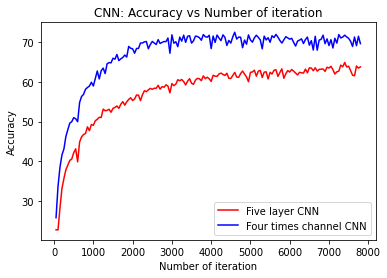

In [27]:
# visualization accuracy 
plt.plot(iteration_list_bii,accuracy_list_bii,color = "red")
plt.plot(iteration_list_biii,accuracy_list_biii,color = "blue")
plt.legend(['Five layer CNN','Four times channel CNN'])
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [28]:
print(summary(model_channel, input_size=(3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 28, 28]           1,824
              ReLU-2           [-1, 24, 28, 28]               0
            Conv2d-3           [-1, 64, 26, 26]          13,888
              ReLU-4           [-1, 64, 26, 26]               0
         MaxPool2d-5           [-1, 64, 13, 13]               0
            Conv2d-6           [-1, 96, 11, 11]          55,392
              ReLU-7           [-1, 96, 11, 11]               0
            Conv2d-8             [-1, 96, 9, 9]          83,040
              ReLU-9             [-1, 96, 9, 9]               0
           Conv2d-10             [-1, 96, 7, 7]          83,040
             ReLU-11             [-1, 96, 7, 7]               0
          Flatten-12                 [-1, 4704]               0
           Linear-13                  [-1, 120]         564,600
             ReLU-14                  [

Increasing the channel size introduces more trainable parameters. The total memory usage of the model is also larger because of that. However, the total trainable parameters are still considerably less than the base CNN. This shows how powerful adding maxpooling and reducing dimension with more CNN is. In addition, this model performs the best out of all other models.